In [40]:
import tensorflow as tf
from tensorflow import keras

from nn.models import C6_4l_clf_maxi_nonprm, swish_activation, C6_4l_clf_maxi
from nn import datasets
from hstar import gghzz, c6, msq
from hzz import zpair, angles

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [41]:
GEN=11
SEED=373485

EVENT_NUM=99

OUTPUT_DIR='outputs/single'
SAMPLE_DIR='..'

In [42]:
sample = gghzz.Process(  
    (1.4783394, SAMPLE_DIR + '/ggZZ2e2m_all_new.csv', 33000),
    (0.47412769, SAMPLE_DIR + '/ggZZ4e_all_new.csv', 33000),
    (0.47412769, SAMPLE_DIR + '/ggZZ4m_all_new.csv', 33000)
)

#sample.events = sample.events[]

In [43]:
#base_size = EVENT_NUM # for train and validation data each

#fraction = 3*base_size/sample.events.kinematics.shape[0] # fraction of the dataset that is actually needed

#sample.events = sample.events.sample(frac=fraction, random_state=SEED)[-base_size:]


z_chooser = zpair.ZPairChooser(bounds1=(50,115), bounds2=(50,115), algorithm='leastsquare')
l1_1, l2_1, l1_2, l2_2 = sample.events.filter(z_chooser)

kin_variables = angles.calculate(l1_1, l2_1, l1_2, l2_2)

print(kin_variables.shape)

c6_values = [-10]

c6_mod = c6.Modifier(amplitude_component = msq.Component.SIG, c6_values = [-5,-1,0,1,5])
c6_weights, c6_prob = c6_mod.modify(sample=sample, c6=c6_values)

(96383, 8)


In [44]:
sig_weights = tf.convert_to_tensor(c6_prob)

bkg_weights = tf.convert_to_tensor(sample[msq.Component.SIG].probabilities)[:,tf.newaxis]

print(sig_weights.shape)

print(bkg_weights.shape)

test_data = tf.concat([tf.convert_to_tensor(kin_variables),sig_weights, bkg_weights], axis=1)

scaler = StandardScaler()

# for GEN 7
#scaler.mean_ = np.array([0.00019189256612400722, 0.6705156706726307, 0.672182766320336, -0.002330860289531429, 0.0006044017928423123, 91.30343432815204, 91.34168283098509, 258.4664139166857])
#scaler.scale_ = np.array([0.87351127, 0.54823019, 0.54611839, 1.79371613, 1.75821199, 5.26457924, 5.23341484, 81.40698443])

# for GEN 8
#scaler.mean_ = np.array([-0.0031632037149649183, 0.6709139748958037, 0.6713568278628346, -0.0013302089262169912, -6.864847530142441e-05, 91.28878797551799, 91.33838398300865, 258.7329571302806])
#scaler.scale_ = np.array([0.8731540510089402, 0.5475399159778886, 0.5468877066551572, 1.7939801195228402, 1.761634667204255, 5.285707478337055, 5.28228227727623, 82.53483099791613])

# for GEN 9
#scaler.mean_ = np.array([0.00019189256612400722, 0.6705156706726307, 0.672182766320336, -0.002330860289531429, 0.0006044017928423123, 91.30343432815204, 91.34168283098509, 258.4664139166857])
#scaler.scale_ = np.array([0.8735112733447693, 0.5482301877890214, 0.5461183930995697, 1.7937161274598072, 1.7582119943056935, 5.264579236544669, 5.233414841237367, 81.40698443389775])

# for GEN 10
#scaler.mean_ = [-0.0031632037149649183, 0.6709139748958037, 0.6713568278628346, -0.0013302089262169912, -6.864847530142441e-05, 91.28878797551799, 91.33838398300865, 258.7329571302806]
#scaler.scale_ = [0.8731540510089402, 0.5475399159778886, 0.5468877066551572, 1.7939801195228402, 1.761634667204255, 5.285707478337055, 5.28228227727623, 82.53483099791613]

# for GEN 11
scaler.mean_ = [0.0041883523529701126, 0.6585512602003579, 0.6590724303775782, 0.008898707902610995, 0.0029265562530066598, 91.70022920117556, 91.71387359595622, 260.1704808930588]
scaler.var_ = [0.7511071029253801, 0.3090641744523269, 0.3097333402758006, 3.1408749557745717, 3.085505507693849, 21.072290878468102, 20.840327899463848, 5322.945363090034]
scaler.scale_ = [0.8666643542487369, 0.555935404927881, 0.5565369172622788, 1.7722513805255087, 1.7565607042439066, 4.590456500008262, 4.565120797904897, 72.95851809823192]

test_data = tf.concat([scaler.transform(test_data[:,:8]), test_data[:,8:]], axis=1)

print(test_data, test_data.shape)

mu = tf.reduce_sum(test_data[:,:8], axis=0)/test_data.shape[0]

print('Mean (after):', mu)

sigma = tf.math.reduce_std(test_data[:,:8], axis=0)

print('sigma (after):', sigma)

(96383, 1)
(96383, 1)
tf.Tensor(
[[-1.15291073e+00  6.02762258e-01  3.22047444e-01 ... -7.44497381e-01
   2.89835229e-07  4.10965658e-07]
 [-1.06943229e+00  6.70514006e-02 -2.53166323e+00 ... -9.83021757e-01
   4.62105956e-06  6.27877642e-06]
 [-9.63232745e-01  5.67440605e-01  5.68881627e-01 ... -4.70036269e-01
   2.64703920e-08  3.98037899e-08]
 ...
 [-3.36371928e-01  3.61602488e-01  5.66499685e-01 ...  1.48346029e+00
   4.31607502e-05  4.11216086e-05]
 [ 1.13566150e+00  5.98217446e-01 -9.71804595e-01 ... -7.99092499e-01
   9.32299994e-07  1.30660079e-06]
 [-1.13472258e+00  5.89297753e-01  6.12321669e-01 ...  1.41651460e-01
   3.11616209e-06  5.28322458e-06]], shape=(96383, 10), dtype=float64) (96383, 10)
Mean (after): tf.Tensor(
[ 0.00267658  0.00853596  0.00727687 -0.00348926 -0.00748355  0.03938016
  0.04594043 -0.01254513], shape=(8,), dtype=float64)
sigma (after): tf.Tensor(
[1.00345868 0.99754188 0.99663433 1.00034102 1.00647535 1.05458137
 1.06237641 0.96387548], shape=(8,), dt

In [45]:
print(test_data, test_data.shape)

tf.Tensor(
[[-1.15291073e+00  6.02762258e-01  3.22047444e-01 ... -7.44497381e-01
   2.89835229e-07  4.10965658e-07]
 [-1.06943229e+00  6.70514006e-02 -2.53166323e+00 ... -9.83021757e-01
   4.62105956e-06  6.27877642e-06]
 [-9.63232745e-01  5.67440605e-01  5.68881627e-01 ... -4.70036269e-01
   2.64703920e-08  3.98037899e-08]
 ...
 [-3.36371928e-01  3.61602488e-01  5.66499685e-01 ...  1.48346029e+00
   4.31607502e-05  4.11216086e-05]
 [ 1.13566150e+00  5.98217446e-01 -9.71804595e-01 ... -7.99092499e-01
   9.32299994e-07  1.30660079e-06]
 [-1.13472258e+00  5.89297753e-01  6.12321669e-01 ...  1.41651460e-01
   3.11616209e-06  5.28322458e-06]], shape=(96383, 10), dtype=float64) (96383, 10)


In [46]:
model = keras.models.load_model(OUTPUT_DIR + f'/ckpt/checkpoint.model_{GEN}.tf', custom_objects={'C6_4l_clf_maxi': C6_4l_clf_maxi, 'swish_activation': swish_activation})

In [47]:
rndint = int(round(np.random.rand()*9))
print(rndint)

data = test_data[:,:8][:,np.newaxis]

print(data)
predictions = model.predict(data, verbose=1)

real_ratios = test_data[:,8]/test_data[:,9]

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

8
tf.Tensor(
[[[-1.15291073  0.60276226  0.32204744 ... -0.05453444 -0.12227547
   -0.74449738]]

 [[-1.06943229  0.0670514  -2.53166323 ...  0.10216204 -0.21132914
   -0.98302176]]

 [[-0.96323275  0.56744061  0.56888163 ... -0.15396629 -0.22504928
   -0.47003627]]

 ...

 [[-0.33637193  0.36160249  0.56649968 ...  0.02363545 -0.04059622
    1.48346029]]

 [[ 1.1356615   0.59821745 -0.9718046  ...  0.46843287 -0.37214122
   -0.7990925 ]]

 [[-1.13472258  0.58929775  0.61232167 ...  0.23295082 -0.20816978
    0.14165146]]], shape=(96383, 1, 8), dtype=float64)
3012/3012 [==============================] - 629s 209ms/step
tf.Tensor(
[[0.6530951 ]
 [0.6525796 ]
 [0.6221441 ]
 ...
 [1.0502026 ]
 [0.61801654]
 [0.6388536 ]], shape=(96383, 1), dtype=float32) tf.Tensor(0.43975314, shape=(), dtype=float32) tf.Tensor(1.1759949, shape=(), dtype=float32)
tf.Tensor([0.70525413 0.73598091 0.6650219  ... 1.04958808 0.71353086 0.589822  ], shape=(96383,), dtype=float64) tf.Tensor(0.34623559259590325, 

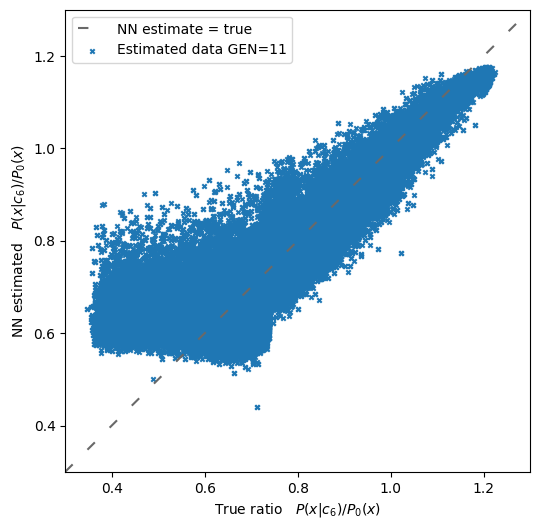

In [48]:
lnspc = np.linspace(0.3,1.3)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data GEN={GEN}')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.3,1.3)
plt.ylim(0.3,1.3)
plt.legend()

plt.show()

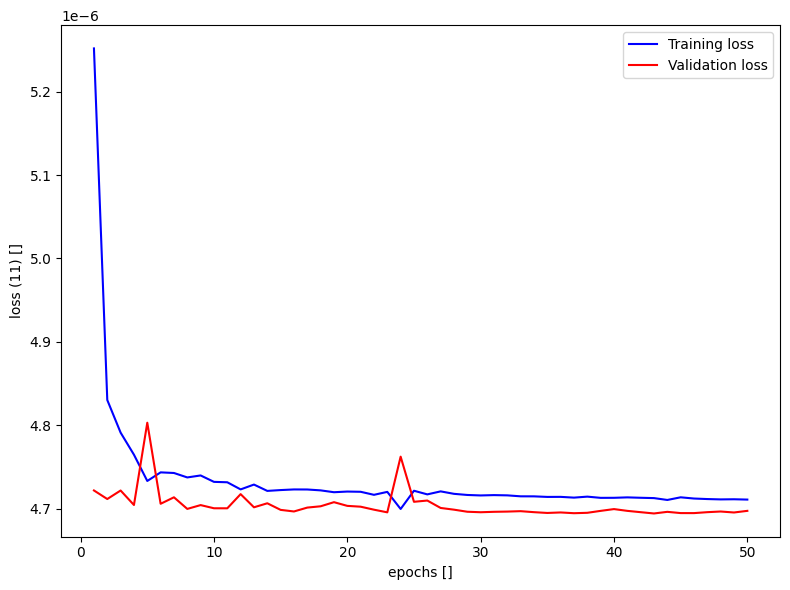

In [49]:
hist_prm = ''

with open(OUTPUT_DIR + f'/history/history_{GEN}.txt', 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss ({GEN}) []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [50]:
predictions = []
real_ratios = []

arr_len = test_data.shape[0]/len(c6_values)

for i in range(len(c6_values)):
    c6 = c6_values[i]
    data = test_data[int(i*arr_len):int((i+0.5)*arr_len),0][:,np.newaxis]
    pred = model.predict(data)
    predictions.append(pred)

    real_ratio = test_data[int(i*arr_len):int((i+0.5)*arr_len),2]/test_data[int((i+0.5)*arr_len):int((i+1)*arr_len),2]
    real_ratios.append(real_ratio)

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios)

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios)

InvalidArgumentError: Graph execution error:

Detected at node c6_4l_clf_maxi_nonprm/dense_44/MatMul defined at (most recent call last):
  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/runpy.py", line 86, in _run_code

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once

  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_103237/89026611.py", line 9, in <module>

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/raven/u/griesemx/ggZZ_work/higgs-offshell-interpretation/nn/models.py", line 96, in call

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,1], In[1]: [8,2000] 0 0
	 [[{{node c6_4l_clf_maxi_nonprm/dense_44/MatMul}}]] [Op:__inference_predict_function_68904]

In [ ]:
real = real_ratios.numpy()
pred = ratios.numpy()

lnspc = np.linspace(0.6,1.2)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label='Estimated data')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()

In [ ]:
hist_prm = ''

with open(f'outputs/m4l/single/history/history_2_m4l.txt', 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,101)

In [ ]:
fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel('loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()